<a href="https://colab.research.google.com/github/JamesPeralta/Machine-Learning-Algorithms/blob/master/Miscellaneous/Visualizing%20what%20covnets%20learn/VisualizingHeatmaps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Visualizing heatmaps of class activation
### This method consists of taking the output feature map of a convolution layerm given an input image, and weighing every channel in that feature map by the gradient of the calss with respect to the channel. We are basically weighing a spatial map of "how intensely the input image activates different channels" . "How intesely the input image activates different channel is with regard to the class"

### Imports

In [0]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np
from keras import backend as K

import os
import matplotlib.pyplot as plt
import cv2

### Mount google drive

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')
elephant_picture = "/content/gdrive/MyDrive/Datasets/CatsAndDogs/creative_commons_elephant-2.jpg"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Training

In [2]:
model = VGG16(weights='imagenet')

Instructions for updating:
Colocations handled automatically by placer.
553467904/553467096 [==============================] - 13s 0us/step


In [0]:
os.chdir("/content/gdrive/My Drive/Datasets/CatsAndDogs/")
elephant_picture = "creative_commons_elephant-2.jpg"

img = image.load_img(elephant_picture, target_size=(224, 224))

x = image.img_to_array(img)

x = np.expand_dims(x, axis=0)

x = preprocess_input(x)

In [11]:
preds= model.predict(x)
print('Predicted:', decode_predictions(preds, top=3)[0])

40960/35363 [==================================] - 0s 2us/step
Predicted: [('n02504458', 'African_elephant', 0.9094207), ('n01871265', 'tusker', 0.08618318), ('n02504013', 'Indian_elephant', 0.0043545896)]


#### Setting up the Grad-CAM algorithm

In [0]:
african_e661ephant_output = model.output[:, 386]
last_conv_layer= model.get_layer('block5_conv3')

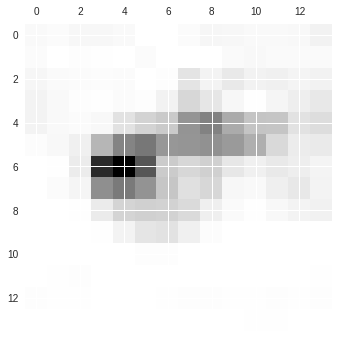

In [28]:
grads = K.gradients(african_e661ephant_output, last_conv_layer.output)[0] 

pooled_grads = K.mean(grads, axis=(0, 1, 2))

iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

pooled_grads_value, conv_layer_output_value = iterate([x])
for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    heatmap = np.mean(conv_layer_output_value, axis=-1)
      
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

#### Superimpose the image on the heatmap 

In [0]:
img = cv2.imread(elephant_picture)

heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

heatmap = np.uint8(255 * heatmap)

heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

superimposed_img = heatmap * 0.4 + img

cv2.imwrite('/content/gdrive', superimposed_img)